In [ ]:
!pip install keras-tcn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 3.0 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from tcn import TCN
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv1D
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
import tensorflow as tf

tf.random.set_seed(0)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Load the data from GDrive
tower8= pd.read_csv("/content/drive/MyDrive/Fault_TolerantProject/tower8Dataa_processed.csv")
tower10= pd.read_csv("/content/drive/MyDrive/Fault_TolerantProject/tower10_data_processed.csv")
tower11= pd.read_csv("/content/drive/MyDrive/Fault_TolerantProject/tower11Data_processed.csv")

In [ ]:

# ? Function to group data by hourly period
def group_data_hourly(data):
    # Convert 'Time' column to HH:MM format
    data['Time'] = data['Time'].apply(lambda x: '{:04}'.format(x))
    data['Time'] = data['Time'].str[:2] + ':' + data['Time'].str[2:]

    # Remove extra colons from 'Time' column
    data['Time'] = data['Time'].str.replace(':', '')

    # Convert 'Date' column to string type
    data['Date'] = data['Date'].astype(str)

    # Combine 'Date' and 'Time' columns to create a new datetime column
    data['DateTime'] = pd.to_datetime(data['Date'] + ' ' + data['Time'], format='%Y%m%d %H%M')

    # Round datetime to the nearest hour
    data['HourlyDateTime'] = data['DateTime'].dt.round('H')

    # Group by hourly datetime and aggregate using mean for specified columns
    hourly_aggregated_data = data.groupby('HourlyDateTime').agg({
        'BatteryVoltage': 'mean',
        'PanelTemperature': 'mean',
        'BarometricPressure': 'mean',
        'Rainfall': 'mean',
        'Temperature_2m': 'mean',
        'RelativeHumidity_2m': 'mean',
        'Temperature_10m': 'mean',
        'SolarRadiation_W/m2': 'mean',
        'SolarRadiation_kW/m2': 'mean'
    }).reset_index()

    return hourly_aggregated_data

In [2]:
# Aggregate at hourly level
tower8_aggregated_data = group_data_hourly(tower8)
tower10_aggregated_data = group_data_hourly(tower10)
tower11_aggregated_data = group_data_hourly(tower11)

# Select required columns from the dfs
tower8_temp= tower8_aggregated_data[["HourlyDateTime", "Temperature_2m", "BarometricPressure"]].copy()
tower10_temp= tower10_aggregated_data[["HourlyDateTime", "Temperature_2m", "BarometricPressure"]].copy()
tower11_temp= tower11_aggregated_data[["HourlyDateTime", "Temperature_2m", "BarometricPressure"]].copy()

print(tower8_temp.shape)
print(tower10_temp.shape)
print(tower11_temp.shape)

NameError: name 'group_data_hourly' is not defined

In [3]:
# concatenate all the towers hourly data
result = pd.concat([tower8_temp, tower10_temp, tower11_temp])
result= result.sort_values(by="HourlyDateTime", ascending= True).copy()
result.shape

NameError: name 'pd' is not defined

LSTM Model Training with Redudant Data

In [ ]:
data= result.copy()
# Preprocessing
data['HourlyDateTime'] = pd.to_datetime(data['HourlyDateTime'])

# Time-based train-test split
data_sorted = data.sort_values(by='HourlyDateTime')
split_index = int(len(data_sorted) * 0.8)  # 80% training, 20% test
train_data = data_sorted.iloc[:split_index]
test_data = data_sorted.iloc[split_index:]

# Prepare sequences for LSTM
sequence_length = 3
X_train = []
y_train = []
X_test = []
y_test = []

for i in range(len(train_data) - sequence_length):
    X_train.append(train_data.iloc[i:i+sequence_length]['Temperature_2m'].values)
    y_train.append(train_data.iloc[i+sequence_length]['Temperature_2m'])

for i in range(len(test_data) - sequence_length):
    X_test.append(test_data.iloc[i:i+sequence_length]['Temperature_2m'].values)
    y_test.append(test_data.iloc[i+sequence_length]['Temperature_2m'])

X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

X_train = X_train.reshape(X_train.shape[0], sequence_length, 1)
X_test = X_test.reshape(X_test.shape[0], sequence_length, 1)

# Build the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))

model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(units=50))
model.add(Dropout(0.2))

model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), verbose=1)

# Evaluate the model
loss = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}')

# Make predictions
predictions = model.predict(X_test)

Epoch 1/50
9/9 [==============================] - 7s 169ms/step - loss: 139.5952 - val_loss: 270.2780
Epoch 2/50
9/9 [==============================] - 0s 11ms/step - loss: 131.5743 - val_loss: 247.4379
Epoch 3/50
9/9 [==============================] - 0s 14ms/step - loss: 110.8812 - val_loss: 190.4421
Epoch 4/50
9/9 [==============================] - 0s 14ms/step - loss: 73.1788 - val_loss: 121.9168
Epoch 5/50
9/9 [==============================] - 0s 11ms/step - loss: 46.7580 - val_loss: 84.9787
Epoch 6/50
9/9 [==============================] - 0s 13ms/step - loss: 37.2067 - val_loss: 69.9813
Epoch 7/50
9/9 [==============================] - 0s 12ms/step - loss: 36.1402 - val_loss: 62.5878
Epoch 8/50
9/9 [==============================] - 0s 12ms/step - loss: 33.2260 - val_loss: 58.3130
Epoch 9/50
9/9 [==============================] - 0s 11ms/step - loss: 30.3134 - val_loss: 55.1304
Epoch 10/50
9/9 [==============================] - 0s 13ms/step - loss: 26.5938 - val_loss: 52.8827
E

In [ ]:
# Calculate RMSE
test_rmse = np.sqrt(mean_squared_error(y_test, predictions))
print(f'Test RMSE: {test_rmse}')

Test RMSE: 2.473724911276311


LSTM Model Training with Unique Data

In [ ]:
data= tower10_temp.copy()
# Preprocessing
data['HourlyDateTime'] = pd.to_datetime(data['HourlyDateTime'])

# Time-based train-test split
data_sorted = data.sort_values(by='HourlyDateTime')
split_index = int(len(data_sorted) * 0.8)  # 80% training, 20% test
train_data = data_sorted.iloc[:split_index]
test_data = data_sorted.iloc[split_index:]

# Prepare sequences for LSTM
sequence_length = 1
X_train = []
y_train = []
X_test = []
y_test = []

for i in range(len(train_data) - sequence_length):
    X_train.append(train_data.iloc[i:i+sequence_length]['Temperature_2m'].values)
    y_train.append(train_data.iloc[i+sequence_length]['Temperature_2m'])

for i in range(len(test_data) - sequence_length):
    X_test.append(test_data.iloc[i:i+sequence_length]['Temperature_2m'].values)
    y_test.append(test_data.iloc[i+sequence_length]['Temperature_2m'])

X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

X_train = X_train.reshape(X_train.shape[0], sequence_length, 1)
X_test = X_test.reshape(X_test.shape[0], sequence_length, 1)

# Build the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))

model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(units=50))
model.add(Dropout(0.2))

model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), verbose=1)

# Evaluate the model
loss = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}')

# Make predictions
predictions = model.predict(X_test)

Epoch 1/50
3/3 [==============================] - 7s 610ms/step - loss: 141.4798 - val_loss: 273.8439
Epoch 2/50
3/3 [==============================] - 0s 19ms/step - loss: 140.8610 - val_loss: 272.8279
Epoch 3/50
3/3 [==============================] - 0s 21ms/step - loss: 140.2339 - val_loss: 271.6849
Epoch 4/50
3/3 [==============================] - 0s 20ms/step - loss: 139.5178 - val_loss: 270.3318
Epoch 5/50
3/3 [==============================] - 0s 28ms/step - loss: 138.6792 - val_loss: 268.6776
Epoch 6/50
3/3 [==============================] - 0s 19ms/step - loss: 137.7095 - val_loss: 266.6288
Epoch 7/50
3/3 [==============================] - 0s 20ms/step - loss: 136.4101 - val_loss: 264.0219
Epoch 8/50
3/3 [==============================] - 0s 20ms/step - loss: 134.5015 - val_loss: 260.6758
Epoch 9/50
3/3 [==============================] - 0s 20ms/step - loss: 132.6870 - val_loss: 256.3360
Epoch 10/50
3/3 [==============================] - 0s 20ms/step - loss: 129.9337 - val_los

In [ ]:
# Calculate RMSE
test_rmse = np.sqrt(mean_squared_error(y_test, predictions))
print(f'Test RMSE: {test_rmse}')

Test RMSE: 6.049070171344582


TCN Model Training with Unique Data


In [ ]:

# Define the lookback window
lookback_window = 1

# Preprocessing
tower10_temp['Hour'] = pd.to_datetime(tower10_temp['HourlyDateTime']).dt.hour
data = tower10_temp.drop(["HourlyDateTime"], axis=1).copy()
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)

# Initialize lists to store input (x) and output (y) data
x, y = [], []

# Create input-output pairs with the specified lookback window
for i in range(lookback_window, len(data_scaled)):
    x.append(data_scaled[i - lookback_window:i])
    y.append(data_scaled[i, 0])  # Assuming RelativeHumidity_2m is the target variable

# Convert lists to numpy arrays
x = np.array(x)
y = np.array(y)

print(x.shape)
print(y.shape)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, shuffle=False)

# Create the TCN Model
model = Sequential([
    TCN(input_shape=(lookback_window, 3),  # assuming 5 features
        kernel_size=3,
        nb_stacks=1,
        use_skip_connections=False,
        use_batch_norm=False,
        use_weight_norm=False,
        use_layer_norm=False
        ),
    Dense(1, activation='linear')
])
model.summary()

# Compile the model
model.compile('adam', 'mse')

# Train the model
print('Training...')
model.fit(X_train, y_train, epochs=200, verbose=0)

# Evaluate the model
train_loss = model.evaluate(X_train, y_train)
test_loss = model.evaluate(X_test, y_test)

print(f'Train Loss: {train_loss}')
print(f'Test Loss: {test_loss}')

# Let's see the performance of the model
train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)

train_rmse = np.sqrt(mean_squared_error(y_train, train_predictions))
test_rmse = np.sqrt(mean_squared_error(y_test, test_predictions))

print(f'Train RMSE: {train_rmse}')
print(f'Test RMSE: {test_rmse}')


(120, 1, 3)
(120,)
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 tcn (TCN)                   (None, 64)                136768    
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 136833 (534.50 KB)
Trainable params: 136833 (534.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Training...
2/2 [==============================] - 0s 8ms/step - loss: 0.0834
Train Loss: 0.004532721824944019
Test Loss: 0.08341415971517563
2/2 [==============================] - 0s 6ms/step
Train RMSE: 0.06732546684627609
Test RMSE: 0.28881513625401406


TCN Model with Redundant Data

In [ ]:
# Define the lookback window
lookback_window = 3

# Preprocessing
result['Hour'] = pd.to_datetime(result['HourlyDateTime']).dt.hour
data = result.drop(["HourlyDateTime"], axis=1).copy()
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)

# Initialize lists to store input (x) and output (y) data
x, y = [], []

# Create input-output pairs with the specified lookback window
for i in range(lookback_window, len(data_scaled)):
    x.append(data_scaled[i - lookback_window:i])
    y.append(data_scaled[i, 0])  # Assuming RelativeHumidity_2m is the target variable

# Convert lists to numpy arrays
x = np.array(x)
y = np.array(y)

print(x.shape)
print(y.shape)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, shuffle=False)

# Create the TCN Model
model = Sequential([
    TCN(input_shape=(lookback_window, 3),  # assuming 5 features
        kernel_size=3,
        nb_stacks=1,
        use_skip_connections=False,
        use_batch_norm=False,
        use_weight_norm=False,
        use_layer_norm=False
        ),
    Dense(1, activation='linear')
])
model.summary()

# Compile the model
model.compile('adam', 'mse')

# Train the model
print('Training...')
model.fit(X_train, y_train, epochs=200, verbose=0)

# Evaluate the model
train_loss = model.evaluate(X_train, y_train)
test_loss = model.evaluate(X_test, y_test)

print(f'Train Loss: {train_loss}')
print(f'Test Loss: {test_loss}')

# Calculate RMSE for training and testing sets
train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)

train_rmse = np.sqrt(mean_squared_error(y_train, train_predictions))
test_rmse = np.sqrt(mean_squared_error(y_test, test_predictions))

print(f'Train RMSE: {train_rmse}')
print(f'Test RMSE: {test_rmse}')

(360, 3, 3)
(360,)
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 tcn_1 (TCN)                 (None, 64)                136768    
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 136833 (534.50 KB)
Trainable params: 136833 (534.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Training...
4/4 [==============================] - 0s 6ms/step - loss: 0.2753
Train Loss: 0.005234765354543924
Test Loss: 0.27528566122055054
4/4 [==============================] - 0s 6ms/step
Train RMSE: 0.07235168281631078
Test RMSE: 0.5246766930523908


Linear Regression with Unique Data (Hour is included as Time *factor*)

In [ ]:
data = tower10_temp.copy()

# Preprocessing
# Convert 'HourlyDateTime' to numerical representation (for simplicity, let's use the hour of the day)
data['Hour'] = pd.to_datetime(data['HourlyDateTime']).dt.hour
# Sort the data by 'HourlyDateTime'
data_sorted = data.sort_values(by='HourlyDateTime')

# Model Building

# Split the dataset into training and testing sets based on time
# Here, we're taking 70% of the data for training and 30% for testing
split_index = int(0.7 * len(data_sorted))
train_data = data_sorted.iloc[:split_index]
test_data = data_sorted.iloc[split_index:]

X_train, X_test = train_data.drop(["HourlyDateTime"], axis=1), test_data.drop(["HourlyDateTime"], axis=1)
y_train, y_test = train_data['Temperature_2m'], test_data['Temperature_2m']

# Train the linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Evaluate the model
train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)

train_rmse = mean_squared_error(y_train, train_predictions, squared=False)
test_rmse = mean_squared_error(y_test, test_predictions, squared=False)

print(f'Train RMSE: {train_rmse}')
print(f'Test RMSE: {test_rmse}')


Train RMSE: 2.3876906720488424e-15
Test RMSE: 2.322520817239588e-15


Linear Regression with Redundant Data (Hour is included as Time *factor*)

In [ ]:
data = result.copy()

# Preprocessing
# Convert 'HourlyDateTime' to numerical representation (for simplicity, let's use the hour of the day)
data['Hour'] = pd.to_datetime(data['HourlyDateTime']).dt.hour
# Sort the data by 'HourlyDateTime'
data_sorted = data.sort_values(by='HourlyDateTime')

# Model Building

# Split the dataset into training and testing sets based on time
# Here, we're taking 70% of the data for training and 30% for testing
split_index = int(0.7 * len(data_sorted))
train_data = data_sorted.iloc[:split_index]
test_data = data_sorted.iloc[split_index:]

X_train, X_test = train_data.drop(["HourlyDateTime"], axis=1), test_data.drop(["HourlyDateTime"], axis=1)
y_train, y_test = train_data['Temperature_2m'], test_data['Temperature_2m']

# Train the linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Evaluate the model
train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)

train_rmse = mean_squared_error(y_train, train_predictions, squared=False)
test_rmse = mean_squared_error(y_test, test_predictions, squared=False)

print(f'Train RMSE: {train_rmse}')
print(f'Test RMSE: {test_rmse}')


Train RMSE: 1.3811551802703754e-15
Test RMSE: 1.5289322063512913e-15


Epoch 1/50
10/10 [==============================] - 3s 69ms/step - loss: 0.9402 - val_loss: 1.0711
Epoch 2/50
10/10 [==============================] - 0s 42ms/step - loss: 0.7104 - val_loss: 1.3683
Epoch 3/50
10/10 [==============================] - 1s 59ms/step - loss: 0.4820 - val_loss: 1.2071
Epoch 4/50
10/10 [==============================] - 0s 34ms/step - loss: 0.3248 - val_loss: 1.3653
Epoch 5/50
10/10 [==============================] - 0s 41ms/step - loss: 0.1931 - val_loss: 1.1398
Epoch 6/50
10/10 [==============================] - 0s 15ms/step - loss: 0.1567 - val_loss: 1.0211
Epoch 7/50
10/10 [==============================] - 0s 13ms/step - loss: 0.1277 - val_loss: 0.9728
Epoch 8/50
10/10 [==============================] - 0s 15ms/step - loss: 0.1233 - val_loss: 0.9845
Epoch 9/50
10/10 [==============================] - 0s 19ms/step - loss: 0.1187 - val_loss: 0.8815
Epoch 10/50
10/10 [==============================] - 0s 25ms/step - loss: 0.1123 - val_loss: 1.0193
Epoch 11/

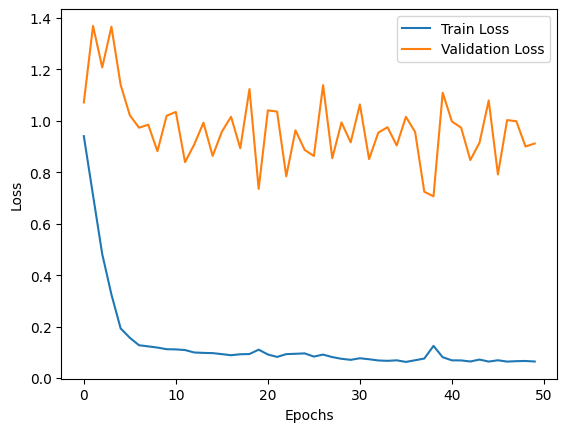

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from keras.models import Model
from keras.layers import Input, Conv1D, MaxPooling1D, Flatten, Dense, RepeatVector, UpSampling1D

data = result.copy()

# Preprocessing
data['Hour'] = pd.to_datetime(data['HourlyDateTime']).dt.hour
X = data[['Hour']].values
y = data['Temperature_2m'].values

# Normalize the data
X_mean = X.mean()
X_std = X.std()
y_mean = y.mean()
y_std = y.std()

X = (X - X_mean) / X_std
y = (y - y_mean) / y_std

# Reshape data for CNN
X = X.reshape((X.shape[0], X.shape[1], 1))
y = y.reshape((y.shape[0], 1, 1))

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Define the Encoder-Decoder-CNN model
# Encoder
encoder_inputs = Input(shape=(X_train.shape[1], X_train.shape[2]))
encoder_conv1 = Conv1D(64, kernel_size=3, activation='relu', padding='same')(encoder_inputs)
encoder_conv2 = Conv1D(128, kernel_size=3, activation='relu', padding='same')(encoder_conv1)
encoder_flat = Flatten()(encoder_conv2)

# Decoder
decoder_repeat = RepeatVector(y_train.shape[1])(encoder_flat)
decoder_conv1 = Conv1D(128, kernel_size=3, activation='relu', padding='same')(decoder_repeat)
decoder_upsample1 = UpSampling1D(size=2)(decoder_conv1)
decoder_conv2 = Conv1D(64, kernel_size=3, activation='relu', padding='same')(decoder_upsample1)
decoder_upsample2 = UpSampling1D(size=2)(decoder_conv2)
decoder_outputs = Conv1D(1, kernel_size=1, activation='linear', padding='same')(decoder_upsample2)

# Model
model = Model(encoder_inputs, decoder_outputs)
model.compile(optimizer='adam', loss='mse')

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), verbose=1)

# Evaluate the model
train_loss = model.evaluate(X_train, y_train)
test_loss = model.evaluate(X_test, y_test)

print(f'Train Loss: {train_loss}')
print(f'Test Loss: {test_loss}')

# Make predictions
train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)

# Plot training and validation loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()



Epoch 1/50
3/3 [==============================] - 7s 373ms/step - loss: 0.9747 - val_loss: 1.0400
Epoch 2/50
3/3 [==============================] - 0s 90ms/step - loss: 0.9201 - val_loss: 1.0723
Epoch 3/50
3/3 [==============================] - 0s 87ms/step - loss: 0.8479 - val_loss: 1.1222
Epoch 4/50
3/3 [==============================] - 0s 64ms/step - loss: 0.7450 - val_loss: 1.2083
Epoch 5/50
3/3 [==============================] - 0s 82ms/step - loss: 0.6353 - val_loss: 1.3806
Epoch 6/50
3/3 [==============================] - 0s 88ms/step - loss: 0.5309 - val_loss: 1.6686
Epoch 7/50
3/3 [==============================] - 0s 56ms/step - loss: 0.5074 - val_loss: 1.9202
Epoch 8/50
3/3 [==============================] - 0s 96ms/step - loss: 0.4767 - val_loss: 1.7256
Epoch 9/50
3/3 [==============================] - 0s 70ms/step - loss: 0.4069 - val_loss: 1.3787
Epoch 10/50
3/3 [==============================] - 0s 73ms/step - loss: 0.3697 - val_loss: 1.2295
Epoch 11/50
3/3 [===========

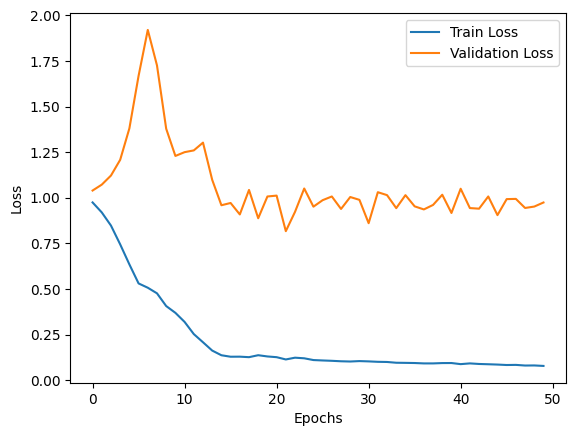

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from keras.models import Model
from keras.layers import Input, Conv1D, MaxPooling1D, Flatten, Dense, RepeatVector, UpSampling1D

data = tower10_temp.copy()

# Preprocessing
data['Hour'] = pd.to_datetime(data['HourlyDateTime']).dt.hour
X = data[['Hour']].values
y = data['Temperature_2m'].values

# Normalize the data
X_mean = X.mean()
X_std = X.std()
y_mean = y.mean()
y_std = y.std()

X = (X - X_mean) / X_std
y = (y - y_mean) / y_std

# Reshape data for CNN
X = X.reshape((X.shape[0], X.shape[1], 1))
y = y.reshape((y.shape[0], 1, 1))

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Define the Encoder-Decoder-CNN model
# Encoder
encoder_inputs = Input(shape=(X_train.shape[1], X_train.shape[2]))
encoder_conv1 = Conv1D(64, kernel_size=3, activation='relu', padding='same')(encoder_inputs)
encoder_conv2 = Conv1D(128, kernel_size=3, activation='relu', padding='same')(encoder_conv1)
encoder_flat = Flatten()(encoder_conv2)

# Decoder
decoder_repeat = RepeatVector(y_train.shape[1])(encoder_flat)
decoder_conv1 = Conv1D(128, kernel_size=3, activation='relu', padding='same')(decoder_repeat)
decoder_upsample1 = UpSampling1D(size=2)(decoder_conv1)
decoder_conv2 = Conv1D(64, kernel_size=3, activation='relu', padding='same')(decoder_upsample1)
decoder_upsample2 = UpSampling1D(size=2)(decoder_conv2)
decoder_outputs = Conv1D(1, kernel_size=1, activation='linear', padding='same')(decoder_upsample2)

# Model
model = Model(encoder_inputs, decoder_outputs)
model.compile(optimizer='adam', loss='mse')

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), verbose=1)

# Evaluate the model
train_loss = model.evaluate(X_train, y_train)
test_loss = model.evaluate(X_test, y_test)

print(f'Train Loss: {train_loss}')
print(f'Test Loss: {test_loss}')

# Make predictions
train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)

# Plot training and validation loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

